In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ultrasound-nerve-segmentation/train_masks.csv
/kaggle/input/ultrasound-nerve-segmentation/sample_submission.csv
/kaggle/input/ultrasound-nerve-segmentation/test/1259.tif
/kaggle/input/ultrasound-nerve-segmentation/test/659.tif
/kaggle/input/ultrasound-nerve-segmentation/test/4794.tif
/kaggle/input/ultrasound-nerve-segmentation/test/274.tif
/kaggle/input/ultrasound-nerve-segmentation/test/315.tif
/kaggle/input/ultrasound-nerve-segmentation/test/919.tif
/kaggle/input/ultrasound-nerve-segmentation/test/3360.tif
/kaggle/input/ultrasound-nerve-segmentation/test/2037.tif
/kaggle/input/ultrasound-nerve-segmentation/test/1819.tif
/kaggle/input/ultrasound-nerve-segmentation/test/3660.tif
/kaggle/input/ultrasound-nerve-segmentation/test/1938.tif
/kaggle/input/ultrasound-nerve-segmentation/test/948.tif
/kaggle/input/ultrasound-nerve-segmentation/test/4303.tif
/kaggle/input/ultrasound-nerve-segmentation/test/5067.tif
/kaggle/input/ultrasound-nerve-segmentation/test/4296.tif
/kaggle/i

In [2]:

import os

import imageio
from PIL import Image
import tifffile
!pip install imagecodecs
import imagecodecs
import cv2

import matplotlib.pyplot as plt

import numpy as np 
from numpy import asarray

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [3]:
def LoadData (path1):
    image_dataset = os.listdir(path1)

    orig_img = []
    mask_img = []
    image_dataset.sort()
    for file in image_dataset:
        if file.endswith('_mask.tif'):
            mask_img.append(file)
            orig_img.append(file.replace("_mask.tif",".tif"))       

    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

(420, 580)
(420, 580)


Text(0.5, 1.0, 'Masked Image 11_113_mask.tif')

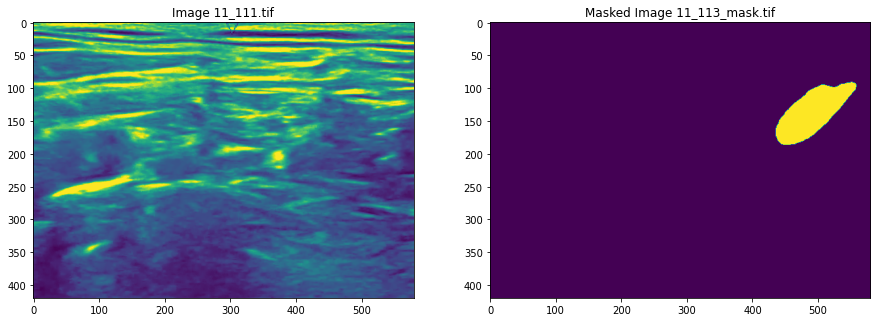

In [5]:
path1 = '../input/ultrasound-nerve-segmentation/train/'
img, mask = LoadData (path1)

show_images = 134

img_view  = imageio.imread(path1 + img[show_images])
mask_view = imageio.imread(path1 + mask[show_images])

print(img_view.shape)
print(mask_view.shape)
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_view)
arr[0].set_title('Image ' + img[show_images])
arr[1].imshow(mask_view)
arr[1].set_title('Masked Image '+ mask[show_images])

In [7]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    m = len(img)                     
    i_h,i_w,i_c = target_shape_img   
    m_h,m_w,m_c = target_shape_mask  

    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    for file in img:
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256.
        X[index] = single_img
        
        single_mask_ind = mask[index]
        path = os.path.join(path1, single_mask_ind)
        single_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        single_mask = cv2.resize(single_mask, dsize=(m_h, m_w), interpolation=cv2.INTER_NEAREST)
        single_mask = asarray(single_mask)
        single_mask = single_mask[..., tf.newaxis]
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask/255
        single_mask = single_mask.astype(int) 
        y[index] = single_mask
    return X, y

X Shape: (5635, 128, 128, 3)
Y shape: (5635, 128, 128, 1)
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

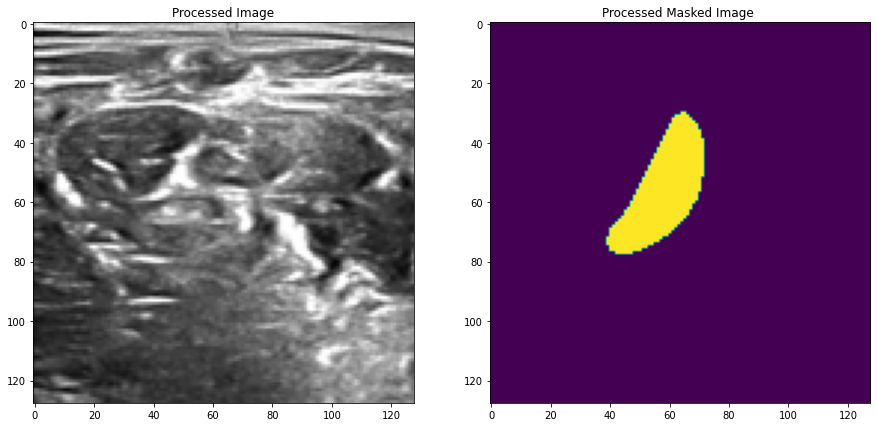

In [8]:
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path1)

print("X Shape:", X.shape)
print("Y shape:", y.shape)
print(np.unique(y))

image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')